[Step 10/100] Immediate Loss: 29.661400873661044 Accumlated Loss: 34.381083221018315
[Step 20/100] Immediate Loss: 21.721210796236996 Accumlated Loss: 24.125531654298307
[Step 30/100] Immediate Loss: 20.717992586493505 Accumlated Loss: 20.629015110522506
[Step 40/100] Immediate Loss: 20.31778262376786 Accumlated Loss: 20.401564517676828
[Step 50/100] Immediate Loss: 21.517062507569797 Accumlated Loss: 20.607605726897724
[Step 60/100] Immediate Loss: 20.558893247246754 Accumlated Loss: 20.390989627033466
[Step 70/100] Immediate Loss: 20.57022605895995 Accumlated Loss: 20.47847183179855
[Step 80/100] Immediate Loss: 19.823867598176 Accumlated Loss: 20.282766120791436
[Step 90/100] Immediate Loss: 20.220103700757026 Accumlated Loss: 20.263966775059696
[Step 100/100] Immediate Loss: 20.07956038057804 Accumlated Loss: 20.539366428911684


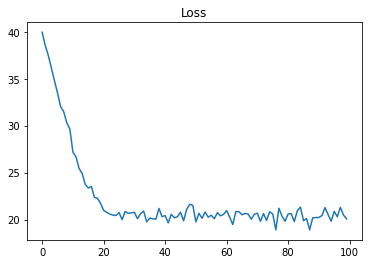

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal

random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        
        # guide 1
        
        self.x1_net_1 = simpleNN()
        self.x2_net_1 = simpleNN()
        self.x3_net_1 = simpleNN()
        self.x4_net_1 = simpleNN()
        self.x5_net_1 = simpleNN()
        self.x6_net_1 = simpleNN()
        self.x7_net_1 = simpleNN()
        self.x8_net_1 = simpleNN()
        self.y1_net_1 = simpleNN()
        self.y2_net_1 = simpleNN()
        self.y3_net_1 = simpleNN()
        self.y4_net_1 = simpleNN()
        self.z1_net_1 = simpleNN()
        self.z2_net_1 = simpleNN()
        
        # guide 2
        self.x1_net_2 = simpleNN(2)
        self.x2_net_2 = simpleNN(2)
        self.x3_net_2 = simpleNN(2)
        self.x4_net_2 = simpleNN(2)
        self.x5_net_2 = simpleNN(2)
        self.x6_net_2 = simpleNN(2)
        self.x7_net_2 = simpleNN(2)
        self.x8_net_2 = simpleNN(2)
        self.y1_net_2 = simpleNN(2)
        self.y2_net_2 = simpleNN(2)
        self.y3_net_2 = simpleNN(2)
        self.y4_net_2 = simpleNN(2)
        self.z1_net_2 = simpleNN()
        self.z2_net_2 = simpleNN()
        
        # guide 3
        self.x1_net_3 = simpleNN(7)
        self.x2_net_3 = simpleNN(7)
        self.x3_net_3 = simpleNN(7)
        self.x4_net_3 = simpleNN(7)
        self.x5_net_3 = simpleNN(7)
        self.x6_net_3 = simpleNN(7)
        self.x7_net_3 = simpleNN(7)
        self.x8_net_3 = simpleNN(7)
        self.y1_net_3 = simpleNN(3)
        self.y2_net_3 = simpleNN(3)
        self.y3_net_3 = simpleNN(3)
        self.y4_net_3 = simpleNN(3)
        self.z1_net_3 = simpleNN()
        self.z2_net_3 = simpleNN()

        # guide 4
        self.x1_net_4 = simpleNN(2)
        self.x2_net_4 = simpleNN()
        self.x3_net_4 = simpleNN(2)
        self.x4_net_4 = simpleNN()
        self.x5_net_4 = simpleNN(2)
        self.x6_net_4 = simpleNN()
        self.x7_net_4 = simpleNN(2)
        self.x8_net_4 = simpleNN()
        self.y1_net_4 = simpleNN(2)
        self.y2_net_4 = simpleNN()
        self.y3_net_4 = simpleNN(2)
        self.y4_net_4 = simpleNN()
        self.z1_net_4 = simpleNN(2)
        self.z2_net_4 = simpleNN()
        
        # guide 5
        self.x1_net_5 = simpleNN(14)
        self.x2_net_5 = simpleNN(13)
        self.x3_net_5 = simpleNN(12)
        self.x4_net_5 = simpleNN(11)
        self.x5_net_5 = simpleNN(10)
        self.x6_net_5 = simpleNN(9)
        self.x7_net_5 = simpleNN(8)
        self.x8_net_5 = simpleNN(7)
        self.y1_net_5 = simpleNN(6)
        self.y2_net_5 = simpleNN(5)
        self.y3_net_5 = simpleNN(4)
        self.y4_net_5 = simpleNN(3)
        self.z1_net_5 = simpleNN(2)
        self.z2_net_5 = simpleNN()
        
        # guide 6
        self.x1_net_6 = simpleNN()
        self.x2_net_6 = simpleNN()
        self.x3_net_6 = simpleNN()
        self.x4_net_6 = simpleNN()
        self.x5_net_6 = simpleNN()
        self.x6_net_6 = simpleNN()
        self.x7_net_6 = simpleNN()
        self.x8_net_6 = simpleNN()
        self.y1_net_6 = simpleNN(2)
        self.y2_net_6 = simpleNN(2)
        self.y3_net_6 = simpleNN(2)
        self.y4_net_6 = simpleNN(2)
        self.z1_net_6 = simpleNN(2)
        self.z2_net_6 = simpleNN(2)
        
        # guide 7
        self.x1_net_7 = simpleNN()
        self.x2_net_7 = simpleNN(2)
        self.x3_net_7 = simpleNN()
        self.x4_net_7 = simpleNN(2)
        self.x5_net_7 = simpleNN()
        self.x6_net_7 = simpleNN(2)
        self.x7_net_7 = simpleNN()
        self.x8_net_7 = simpleNN(2)
        self.y1_net_7 = simpleNN(2)
        self.y2_net_7 = simpleNN(3)
        self.y3_net_7 = simpleNN(2)
        self.y4_net_7 = simpleNN(3)
        self.z1_net_7 = simpleNN(2)
        self.z2_net_7 = simpleNN(3)
    
    # a tree model
    def model(self, obs):
        pyro.module("model", self)
        x1 = pyro.sample("x1", dist.Normal(0, 1.0))
        x2 = pyro.sample("x2", dist.Normal(0, 1.0))
        x3 = pyro.sample("x3", dist.Normal(0, 1.0))
        x4 = pyro.sample("x4", dist.Normal(0, 1.0))
        x5 = pyro.sample("x5", dist.Normal(0, 1.0))
        x6 = pyro.sample("x6", dist.Normal(0, 1.0))
        x7 = pyro.sample("x7", dist.Normal(0, 1.0))
        x8 = pyro.sample("x8", dist.Normal(0, 1.0))
        y1 = pyro.sample("y1", dist.Normal(x1+x2, 1.0))
        y2 = pyro.sample("y2", dist.Normal(x3+x4, 1.0))
        y3 = pyro.sample("y3", dist.Normal(x5+x6, 1.0))
        y4 = pyro.sample("y4", dist.Normal(x7+x8, 1.0))
        z1 = pyro.sample("z1", dist.Normal(y1+y2, 1.0))
        z2 = pyro.sample("z2", dist.Normal(y3+y4, 1.0))
        pyro.sample("obs", dist.Normal(z1+z2, 1.0), obs=obs)
        
    # guide 1 basically inverse the arrows in the model
    def guide_1(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_1([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_1([obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_1([z2])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_1([z2])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_1([z1])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_1([z1])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_1([y4])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_1([y4])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_1([y3])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_1([y3])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_1([y2])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_1([y2])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_1([y1])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_1([y1])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
    
    # guide 2 inverse the arrows in the model and add obs as dependency for each RV 
    def guide_2(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_2([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_2([obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_2([z2, obs])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_2([z2, obs])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_2([z1, obs])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_2([z1, obs])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_2([y4, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_2([y4, obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_2([y3, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_2([y3, obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_2([y2, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_2([y2, obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_2([y1, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_2([y1, obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
    
    # guide 3 inverse the arrows and each RV depends on all RVs in previous levels
    # i.e. x depends on all y + z + obs
    def guide_3(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_3([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_3([obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_3([z1, z2, obs])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_3([z1, z2, obs])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_3([z1, z2, obs])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_3([z1, z2, obs])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_3([y1, y2, y3, y4, z1, z2, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_3([y1, y2, y3, y4, z1, z2, obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_3([y1, y2, y3, y4, z1, z2, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_3([y1, y2, y3, y4, z1, z2, obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_3([y1, y2, y3, y4, z1, z2, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_3([y1, y2, y3, y4, z1, z2, obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_3([y1, y2, y3, y4, z1, z2, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_3([y1, y2, y3, y4, z1, z2, obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
    
    # guide 4 inverse the arrows and each RV depends on its previously sampled sibling (if any) at the same level
    # i.e. x1 depends on y1 and x2, y1 depends on z1 and y2, y3 depends on z2 and y4
    # this should be minimum failthful
    def guide_4(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_4([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_4([z2, obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_4([z2])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_4([y4, z2])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_4([z1])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_4([y2, z1])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_4([y4])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_4([x8, y4])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_4([y3])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_4([x6, y3])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_4([y2])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_4([x4, y2])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_4([y1])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_4([x2, y1])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
    
    # guide 5 inverse the arrows and each RV depends on all previously sampled RV
    # fully-connected
    def guide_5(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_5([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_5([z2, obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_5([z1, z2, obs])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_5([y4, z1, z2, obs])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_5([y3, y4, z1, z2, obs])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_5([y2, y3, y4, z1, z2, obs])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_5([y1, y2, y3, y4, z1, z2, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_5([x8, y1, y2, y3, y4, z1, z2, obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_5([x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_5([x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_5([x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_5([x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_5([x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_5([x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
        
    # guide 6 the order to sample RV is the same as the model but given obs as dependency for xs
    def guide_6(self, obs):
        pyro.module("model", self)

        x1_mean, x1_std = self.x1_net_6([obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
        x2_mean, x2_std = self.x2_net_6([obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x3_mean, x3_std = self.x3_net_6([obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x4_mean, x4_std = self.x4_net_6([obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))        
        x5_mean, x5_std = self.x5_net_6([obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x6_mean, x6_std = self.x6_net_6([obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))        
        x7_mean, x7_std = self.x7_net_6([obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x8_mean, x8_std = self.x8_net_6([obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        y1_mean, y1_std = self.y1_net_6([x1, x2])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))        
        y2_mean, y2_std = self.y2_net_6([x3, x4])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))        
        y3_mean, y3_std = self.y3_net_6([x5, x6])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))        
        y4_mean, y4_std = self.y4_net_6([x7, x8])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))        
        z1_mean, z1_std = self.z1_net_6([y1, y2])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))        
        z2_mean, z2_std = self.z2_net_6([y3, y4])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
    
    # guide 7 is similar to guide 6 but each RV dependent on its subling
    # the inverse of guide 4
    def guide_7(self, obs):
        pyro.module("model", self)

        x1_mean, x1_std = self.x1_net_7([obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
        x2_mean, x2_std = self.x2_net_7([x1, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x3_mean, x3_std = self.x3_net_7([obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x4_mean, x4_std = self.x4_net_7([x3, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))        
        x5_mean, x5_std = self.x5_net_7([obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x6_mean, x6_std = self.x6_net_7([x5, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))        
        x7_mean, x7_std = self.x7_net_7([obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x8_mean, x8_std = self.x8_net_7([x7, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        y1_mean, y1_std = self.y1_net_7([x1, x2])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))        
        y2_mean, y2_std = self.y2_net_7([x3, x4, y1])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))        
        y3_mean, y3_std = self.y3_net_7([x5, x6])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))        
        y4_mean, y4_std = self.y4_net_7([x7, x8, y3])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))        
        z1_mean, z1_std = self.z1_net_7([y1, y2])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))        
        z2_mean, z2_std = self.z2_net_7([y3, y4, z1])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        
def generate_data():
    x_len = 8
    xs = torch.randn(x_len)
    ys = []
    i = 0
    while i < len(xs):
        y = dist.Normal(xs[i] + xs[i+1], 2).sample()
        ys.append(y)
        i +=2
        
    zs = []
    i = 0
    while i < len(ys):
        z = dist.Normal(ys[i] + ys[i+1], 1.5).sample()
        zs.append(z)
        i +=2
        
        
    obs = dist.Normal(zs[0] + zs[1], 1).sample()
    return obs
    
        
data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

#print(data)
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
#guide = experiment.guide_4 # guide_1

# pyro auto guide
guide = AutoNormal(experiment.model)
#guide = AutoMultivariateNormal(experiment.model)
#guide = AutoDiagonalNormal(experiment.model)

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())


n_steps = 100
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for obs in data:
        imme_loss += svi.step(obs) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

In [2]:
# guide 1
[Step 10/100] Immediate Loss: 5.6792811819911035 Accumlated Loss: 8.161501753419639
[Step 20/100] Immediate Loss: 5.6724499085545546 Accumlated Loss: 5.7964787363111965
[Step 30/100] Immediate Loss: 5.761731808781624 Accumlated Loss: 5.581517954558135
[Step 40/100] Immediate Loss: 6.112146431803706 Accumlated Loss: 5.703019751578569
[Step 50/100] Immediate Loss: 5.990561635196209 Accumlated Loss: 5.61033443725109
[Step 60/100] Immediate Loss: 5.79047949910164 Accumlated Loss: 5.709876654744148
[Step 70/100] Immediate Loss: 5.865784194469453 Accumlated Loss: 5.6813742448389535
[Step 80/100] Immediate Loss: 5.5839250811934455 Accumlated Loss: 5.665409379035234
[Step 90/100] Immediate Loss: 5.802031826376916 Accumlated Loss: 5.689023856550455
[Step 100/100] Immediate Loss: 5.711089228987696 Accumlated Loss: 5.733322246074676

SyntaxError: invalid syntax (<ipython-input-2-54276383af52>, line 2)

In [ ]:
# guide 2
[Step 10/100] Immediate Loss: 6.268227699697018 Accumlated Loss: 9.823156678080556
[Step 20/100] Immediate Loss: 6.012787947654725 Accumlated Loss: 6.139076143831014
[Step 30/100] Immediate Loss: 6.102070910632606 Accumlated Loss: 5.927030056893825
[Step 40/100] Immediate Loss: 6.45776209264994 Accumlated Loss: 5.981230340063572
[Step 50/100] Immediate Loss: 6.256524928808213 Accumlated Loss: 5.893774724751712
[Step 60/100] Immediate Loss: 6.069752818644045 Accumlated Loss: 5.9795956534147265
[Step 70/100] Immediate Loss: 6.092835750877859 Accumlated Loss: 5.928910363674163
[Step 80/100] Immediate Loss: 5.949914609193803 Accumlated Loss: 5.921238815844059
[Step 90/100] Immediate Loss: 6.110138435661791 Accumlated Loss: 5.9243319559395315
[Step 100/100] Immediate Loss: 5.967664820253849 Accumlated Loss: 5.956207058787346

In [ ]:
# guide 3
[Step 10/100] Immediate Loss: 6.570058162808415 Accumlated Loss: 9.397841033637526
[Step 20/100] Immediate Loss: 6.147684178054332 Accumlated Loss: 6.235418024212122
[Step 30/100] Immediate Loss: 6.111919716298578 Accumlated Loss: 5.938203674733639
[Step 40/100] Immediate Loss: 6.531079505085945 Accumlated Loss: 5.937320747315884
[Step 50/100] Immediate Loss: 6.133750829696654 Accumlated Loss: 5.836949352592229
[Step 60/100] Immediate Loss: 5.995875943303109 Accumlated Loss: 5.909800890862941
[Step 70/100] Immediate Loss: 6.01717264592648 Accumlated Loss: 5.870649518340828
[Step 80/100] Immediate Loss: 5.837504681944848 Accumlated Loss: 5.835405748039484
[Step 90/100] Immediate Loss: 6.031392835974693 Accumlated Loss: 5.827427438616752
[Step 100/100] Immediate Loss: 5.949472520351413 Accumlated Loss: 5.865983818709852

In [ ]:
### guide 4 ### best
[Step 10/100] Immediate Loss: 4.377868088781835 Accumlated Loss: 6.545501601159573
[Step 20/100] Immediate Loss: 3.575750644803046 Accumlated Loss: 4.03719574072957
[Step 30/100] Immediate Loss: 3.5968227416276943 Accumlated Loss: 3.657659743905067
[Step 40/100] Immediate Loss: 3.5601295506954207 Accumlated Loss: 3.6178785299956795
[Step 50/100] Immediate Loss: 3.4762910395860662 Accumlated Loss: 3.543176322728395
[Step 60/100] Immediate Loss: 3.52601896584034 Accumlated Loss: 3.533123803049326
[Step 70/100] Immediate Loss: 3.449901377856731 Accumlated Loss: 3.498376666098833
[Step 80/100] Immediate Loss: 3.472165140509606 Accumlated Loss: 3.527985264599323
[Step 90/100] Immediate Loss: 3.535960964262485 Accumlated Loss: 3.4987394436597814
[Step 100/100] Immediate Loss: 3.4975102710723887 Accumlated Loss: 3.5023412067890174

In [ ]:
# guide 5
[Step 10/100] Immediate Loss: 5.436824112832545 Accumlated Loss: 7.459522048622368
[Step 20/100] Immediate Loss: 4.522601895034313 Accumlated Loss: 4.697016129463912
[Step 30/100] Immediate Loss: 4.035572609305381 Accumlated Loss: 4.087585103064775
[Step 40/100] Immediate Loss: 3.9674540817737576 Accumlated Loss: 3.922967136412859
[Step 50/100] Immediate Loss: 3.819277352690697 Accumlated Loss: 3.8670592607259744
[Step 60/100] Immediate Loss: 3.8970872554183003 Accumlated Loss: 3.8228334636390207
[Step 70/100] Immediate Loss: 3.6495595994591716 Accumlated Loss: 3.728844232827424
[Step 80/100] Immediate Loss: 3.6761886674165725 Accumlated Loss: 3.7416907757222653
[Step 90/100] Immediate Loss: 3.6880584159493455 Accumlated Loss: 3.6743881301581856
[Step 100/100] Immediate Loss: 3.7141958668828003 Accumlated Loss: 3.684455200225115

In [ ]:
# guide 6
[Step 10/100] Immediate Loss: 8.01269422084093 Accumlated Loss: 15.49425634944439
[Step 20/100] Immediate Loss: 6.9067663696408275 Accumlated Loss: 7.9501663804352285
[Step 30/100] Immediate Loss: 8.029220328330993 Accumlated Loss: 8.010903750896453
[Step 40/100] Immediate Loss: 8.31351687759161 Accumlated Loss: 8.1114898557961
[Step 50/100] Immediate Loss: 8.786913882493973 Accumlated Loss: 7.755306751757858
[Step 60/100] Immediate Loss: 7.783528136909008 Accumlated Loss: 7.7925652467012405
[Step 70/100] Immediate Loss: 8.006914387047292 Accumlated Loss: 7.681327867358923
[Step 80/100] Immediate Loss: 8.374721429347991 Accumlated Loss: 7.807788733184337
[Step 90/100] Immediate Loss: 7.715019945800301 Accumlated Loss: 7.808754653304815
[Step 100/100] Immediate Loss: 8.256794970929624 Accumlated Loss: 7.728429790437221

In [ ]:
# guide 7
[Step 10/100] Immediate Loss: 7.946083300113675 Accumlated Loss: 15.880016953587534
[Step 20/100] Immediate Loss: 6.707426010072232 Accumlated Loss: 7.429752558678389
[Step 30/100] Immediate Loss: 6.904689866006373 Accumlated Loss: 7.198620594471693
[Step 40/100] Immediate Loss: 7.047841712534428 Accumlated Loss: 7.0875664424300195
[Step 50/100] Immediate Loss: 7.573134193122387 Accumlated Loss: 6.855033908337354
[Step 60/100] Immediate Loss: 7.103918403685091 Accumlated Loss: 6.874631712168455
[Step 70/100] Immediate Loss: 6.944367031455041 Accumlated Loss: 6.938687078088522
[Step 80/100] Immediate Loss: 7.446044615507124 Accumlated Loss: 7.044109266996383
[Step 90/100] Immediate Loss: 6.661473557949067 Accumlated Loss: 6.902258327007294
[Step 100/100] Immediate Loss: 7.03185636729002 Accumlated Loss: 6.8993669908344755

In [ ]:
# autoNormal 
[Step 10/100] Immediate Loss: 29.661400873661044 Accumlated Loss: 34.381083221018315
[Step 20/100] Immediate Loss: 21.721210796236996 Accumlated Loss: 24.125531654298307
[Step 30/100] Immediate Loss: 20.717992586493505 Accumlated Loss: 20.629015110522506
[Step 40/100] Immediate Loss: 20.31778262376786 Accumlated Loss: 20.401564517676828
[Step 50/100] Immediate Loss: 21.517062507569797 Accumlated Loss: 20.607605726897724
[Step 60/100] Immediate Loss: 20.558893247246754 Accumlated Loss: 20.390989627033466
[Step 70/100] Immediate Loss: 20.57022605895995 Accumlated Loss: 20.47847183179855
[Step 80/100] Immediate Loss: 19.823867598176 Accumlated Loss: 20.282766120791436
[Step 90/100] Immediate Loss: 20.220103700757026 Accumlated Loss: 20.263966775059696
[Step 100/100] Immediate Loss: 20.07956038057804 Accumlated Loss: 20.539366428911684

In [ ]:
# AutoMultivariateNormal
[Step 10/100] Immediate Loss: 29.280232212543496 Accumlated Loss: 34.96955828201771
[Step 20/100] Immediate Loss: 20.823702557683003 Accumlated Loss: 23.777785731434825
[Step 30/100] Immediate Loss: 17.56564211547375 Accumlated Loss: 18.975887567698955
[Step 40/100] Immediate Loss: 18.09688677370549 Accumlated Loss: 18.158192227423196
[Step 50/100] Immediate Loss: 17.358041861653323 Accumlated Loss: 17.932833659708496
[Step 60/100] Immediate Loss: 17.660284592509267 Accumlated Loss: 17.789189765751363
[Step 70/100] Immediate Loss: 16.889609196186065 Accumlated Loss: 17.35965327256918
[Step 80/100] Immediate Loss: 18.56209426760674 Accumlated Loss: 17.78802405971289
[Step 90/100] Immediate Loss: 17.714577720761305 Accumlated Loss: 17.483879809975623
[Step 100/100] Immediate Loss: 16.55987268984317 Accumlated Loss: 17.230655351817603

In [ ]:
# AutoDiagonalNormal
[Step 10/100] Immediate Loss: 29.594689139127723 Accumlated Loss: 35.09126758885384
[Step 20/100] Immediate Loss: 22.305745403170594 Accumlated Loss: 24.653422838687895
[Step 30/100] Immediate Loss: 19.765058637857443 Accumlated Loss: 20.882928909182546
[Step 40/100] Immediate Loss: 20.646754955649378 Accumlated Loss: 20.50682894957065
[Step 50/100] Immediate Loss: 20.2246539914608 Accumlated Loss: 20.506671326756482
[Step 60/100] Immediate Loss: 21.094068167805677 Accumlated Loss: 20.755982849299905
[Step 70/100] Immediate Loss: 20.336222262978545 Accumlated Loss: 20.427405071496963
[Step 80/100] Immediate Loss: 21.357484986782072 Accumlated Loss: 20.727729279518126
[Step 90/100] Immediate Loss: 21.060880010724066 Accumlated Loss: 20.713297606468206
[Step 100/100] Immediate Loss: 20.076601029038425 Accumlated Loss: 20.360575951337818